**Pneumonia :** is a lung infection that can be caused by bacteria, viruses, or fungi.

This dataset predict that a person has pneumonia or not by seeing x-ray of lungs.


#Chest X-Ray Images (Pneumonia)

In [ ]:
#directly used kaggle data through kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#convert zip into csv
import zipfile
zip_ref=zipfile.ZipFile('/content/chest-xray-pneumonia.zip','a')
zip_ref.extractall('/content')
zip_ref.close()


#Import necessay packages

In [ ]:
import os
import glob
import random as rn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


sns.set_theme(style="whitegrid", palette="deep")


#Load the dataset


In [ ]:
import tensorflow as tf
from tensorflow import keras

train_ds = keras.utils.image_dataset_from_directory( # Changed 'Keras' to 'keras'
    directory='/content/chest_xray/train',
    labels='inferred',
    label_mode='int', #int becoz it asign 0 to cat and 1 to dog
    batch_size=32,
    image_size=(196,196)
)

test_ds = keras.utils.image_dataset_from_directory( # Changed 'Keras' to 'keras'
    directory='/content/chest_xray/test',
    labels='inferred',
    label_mode='int', #int becoz it asign 0 to cat and 1 to dog
    batch_size=32,
    image_size=(196,196)
)

val_ds = keras.utils.image_dataset_from_directory( # Changed 'Keras' to 'keras'
    directory='/content/chest_xray/val',
    labels='inferred',

    batch_size=32,
    image_size=(196,196)
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


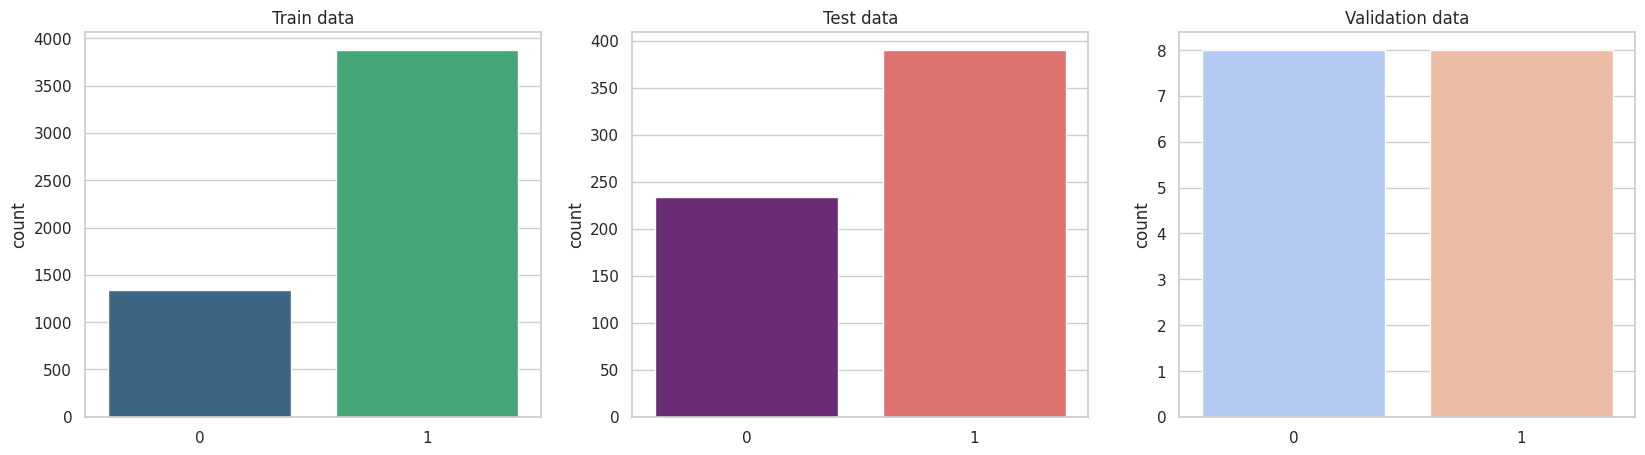

In [ ]:
# Extract labels from datasets
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
test_labels = np.concatenate([y for x, y in test_ds], axis=0)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)

plt.figure(figsize=(20,5))

plt.subplot(1,3,1)
sns.countplot(x=train_labels,palette='viridis') # Changed from train_ds['label'] to train_labels
plt.title('Train data')

plt.subplot(1,3,2)
sns.countplot(x=test_labels , palette='magma') # Changed from test_ds['label'] to test_labels
plt.title('Test data')

plt.subplot(1,3,3)
sns.countplot(x=val_labels , palette='coolwarm') # Changed from val_ds['label'] to val_labels
plt.title('Validation data')

plt.show()

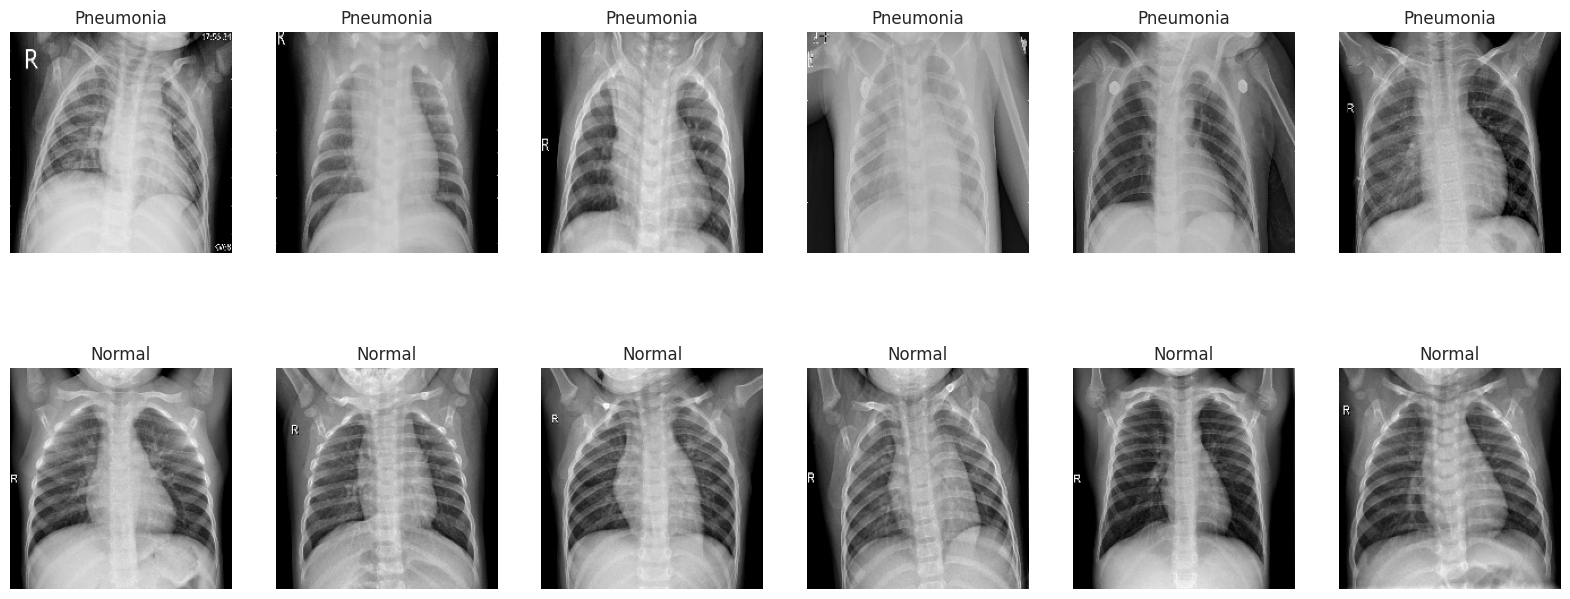

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 8))

# Initialize counters
pneumonia_count = 0
normal_count = 0

# Iterate over the dataset
for images, labels in train_ds.take(1):
    for i in range(len(labels)):
        if labels[i] == 1 and pneumonia_count < 6:  # Check label for Pneumonia
            plt.subplot(2, 6, pneumonia_count + 1)
            plt.axis('off')
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title('Pneumonia')
            pneumonia_count += 1

        elif labels[i] == 0 and normal_count < 6:  # Check label for Normal
            plt.subplot(2, 6, 6 + normal_count + 1)
            plt.axis('off')
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title('Normal')
            normal_count += 1

        # Break if both categories have 6 images
        if pneumonia_count == 6 and normal_count == 6:
            break

plt.show()


In [ ]:
import numpy as np

def process_data(image, label):
    # Changed function signature to accept image and label directly
    img = cv2.resize(image.numpy(), (196, 196))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (196,196,1))

    return img, label

def compose_dataset(dataset):
    # Changed function signature to accept TensorFlow dataset
    data = []
    labels = []

    for images, batch_labels in dataset:  # Iterate over dataset batches
        for i in range(len(batch_labels)):
            img, label = process_data(images[i], batch_labels[i]) # Process individual image and label
            data.append(img)
            labels.append(label)

    return np.array(data), np.array(labels)

X_train, y_train = compose_dataset(train_ds)
X_test, y_test = compose_dataset(test_ds)
X_val, y_val = compose_dataset(val_ds)

print('Train data shape: {}, Labels shape: {}'.format(X_train.shape, y_train.shape))
print('Test data shape: {}, Labels shape: {}'.format(X_test.shape, y_test.shape))
print('Validation data shape: {}, Labels shape: {}'.format(X_val.shape, y_val.shape))

Train data shape: (5216, 196, 196, 1), Labels shape: (5216,)
Test data shape: (624, 196, 196, 1), Labels shape: (624,)
Validation data shape: (16, 196, 196, 1), Labels shape: (16,)


In [ ]:
#image augemnetation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range = 0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

# fit generator on our train features
datagen.fit(X_train)


In [ ]:

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:

model = Sequential()

model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu', input_shape=(196, 196, 1)))
model.add(Conv2D(filters=8, kernel_size=(7,7), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3)))

model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

# Changed 'lr' to 'learning_rate'
optimizer = Adam(learning_rate=0.0001, decay=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)                   │ (None, 196, 196, 8)         │             400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 196, 196, 8)         │           3,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 65, 65, 8)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 65, 65, 16)          │           3,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 65, 65, 16)          │           6,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 21, 21, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 21, 21, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 21, 21, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 10, 10, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_26 (Conv2D)                   │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_27 (Conv2D)                   │ (None, 10, 10, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_28 (Conv2D)                   │ (None, 5, 5, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 5, 5, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 369,850 (1.41 MB)

 Trainable params: 369,850 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
callback = EarlyStopping(monitor='loss', patience=6)
history = model.fit(datagen.flow(X_train,y_train, batch_size=4), validation_data=(X_test, y_test), epochs = 20, verbose = 1, callbacks=[callback], class_weight={0:6.0, 1:0.5})


Epoch 1/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 29s 18ms/step - accuracy: 0.3997 - loss: 0.8246 - val_accuracy: 0.8446 - val_loss: 0.4110
Epoch 2/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 38s 17ms/step - accuracy: 0.8183 - loss: 0.3943 - val_accuracy: 0.8446 - val_loss: 0.3934
Epoch 3/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 42s 18ms/step - accuracy: 0.8380 - loss: 0.3374 - val_accuracy: 0.8558 - val_loss: 0.3648
Epoch 4/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8395 - loss: 0.3231 - val_accuracy: 0.7708 - val_loss: 0.5105
Epoch 5/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8476 - loss: 0.3090 - val_accuracy: 0.8782 - val_loss: 0.3409
Epoch 6/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - accuracy: 0.8492 - loss: 0.2832 - val_accuracy: 0.8734 - val_loss: 0.3255
Epoch 7/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - accuracy: 0.8775 - loss: 0.2504 - val_accuracy: 0.8830 - val_loss: 0.2937
Epoch 8/20
1304/1304 ━━━━━━━━━━━━━━━━━━━━ 23s 17ms/step - accuracy: 0.8945 -

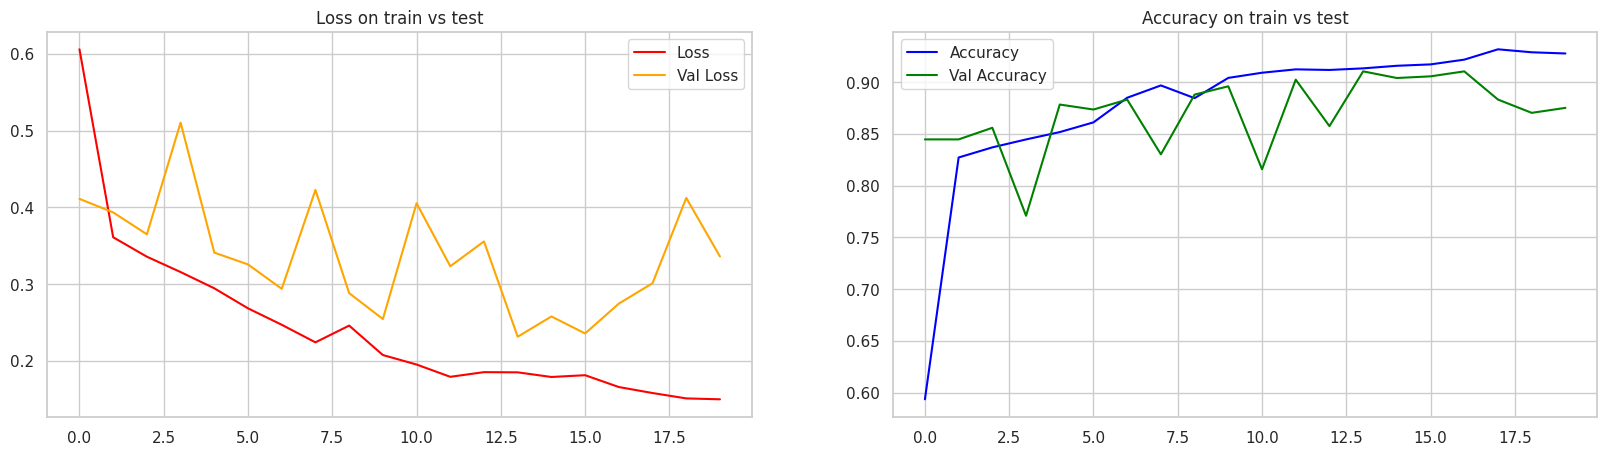

In [ ]:
plt.figure(figsize=(20,5))

# plot loss & val loss
plt.subplot(1,2,1)
sns.lineplot(x=history.epoch, y=history.history['loss'], color='red', label='Loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], color='orange', label='Val Loss')
plt.title('Loss on train vs test')
plt.legend(loc='best')

# plot accuracy and val accuracy
plt.subplot(1,2,2)
sns.lineplot(x=history.epoch, y=history.history['accuracy'], color='blue', label='Accuracy')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], color='green', label='Val Accuracy')
plt.title('Accuracy on train vs test')
plt.legend(loc='best')

plt.show()


156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


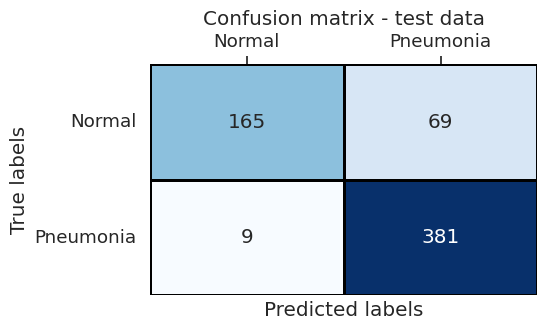

Classification report on test data
              precision    recall  f1-score   support

           0       0.95      0.71      0.81       234
           1       0.85      0.98      0.91       390

    accuracy                           0.88       624
   macro avg       0.90      0.84      0.86       624
weighted avg       0.88      0.88      0.87       624



In [ ]:
y_test_hat = model.predict(X_test, batch_size=4)
y_test_hat = np.argmax(y_test_hat, axis=1)
y_test = np.argmax(y_test, axis=1)


# calculate confusion matrix & classification report
conf_m = confusion_matrix(y_test, y_test_hat)
clas_r = classification_report(y_test, y_test_hat)

# plot confusion matrix as heatmap
plt.figure(figsize=(5,3))
sns.set(font_scale=1.2)
ax = sns.heatmap(conf_m, annot=True,xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'], cbar=False, cmap='Blues',linewidths=1, linecolor='black', fmt='.0f')
plt.yticks(rotation=0)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
ax.xaxis.set_ticks_position('top')
plt.title('Confusion matrix - test data')
plt.show()

# print classification report
print('Classification report on test data')
print(clas_r)


In [ ]:

y_val_hat = model.predict(X_val, batch_size=4)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


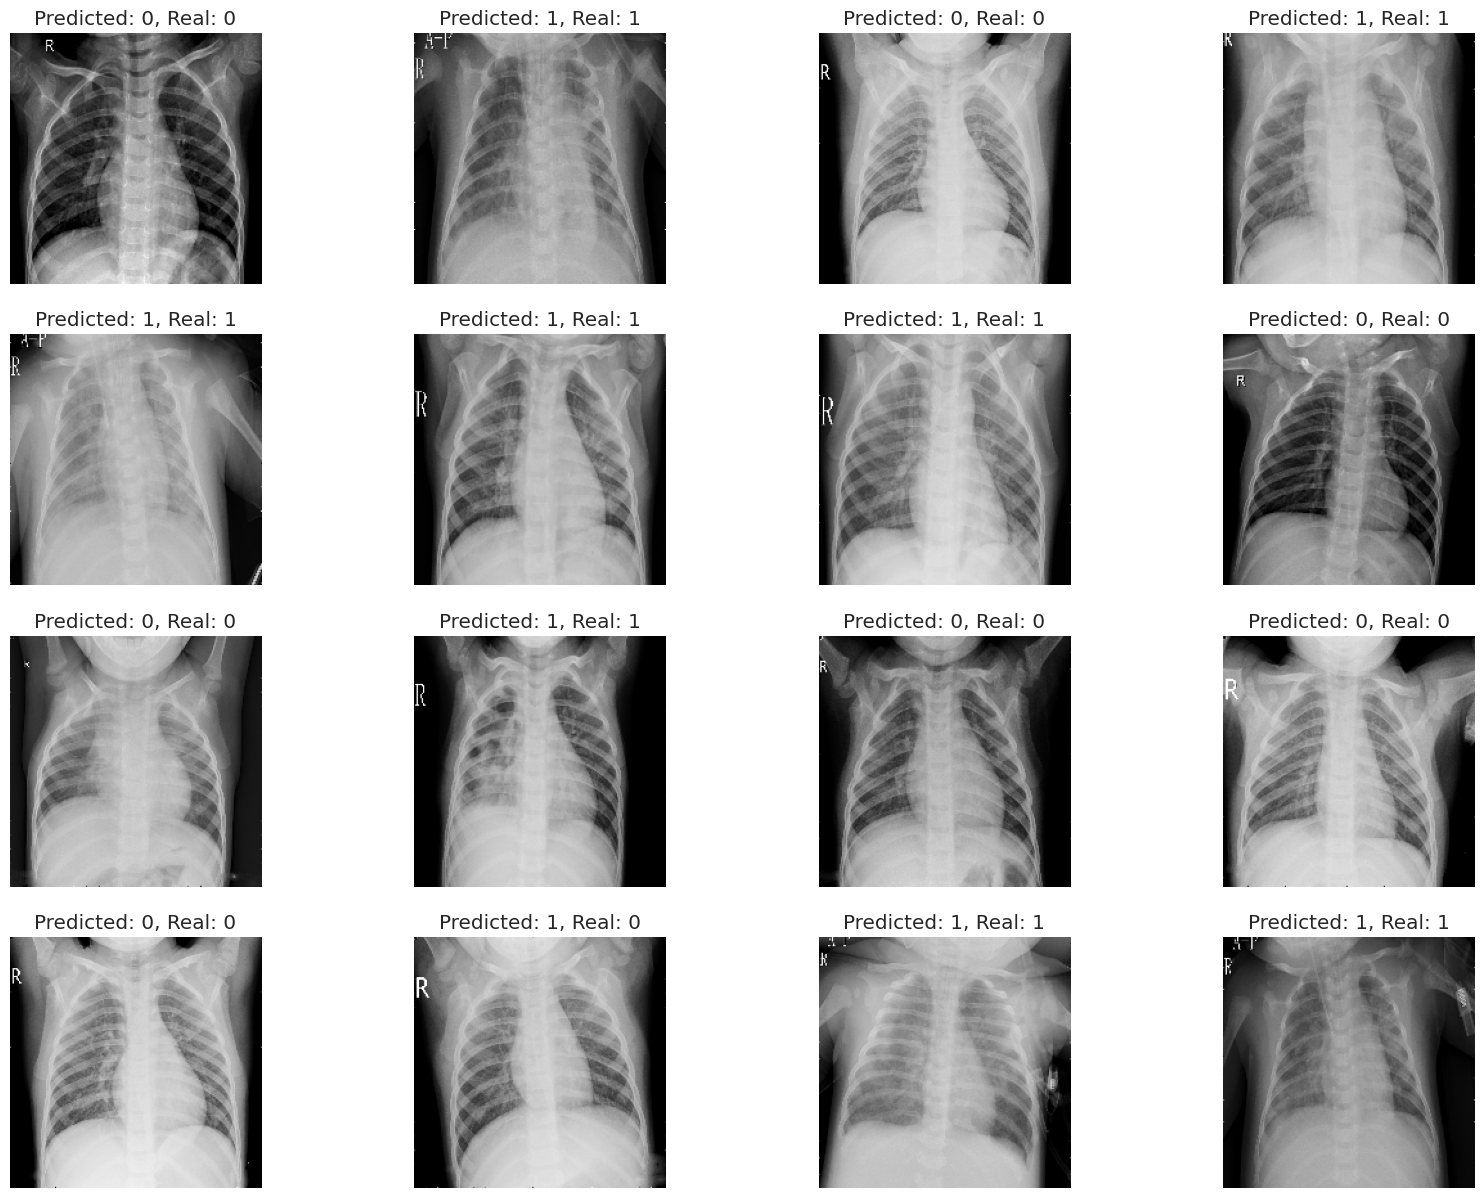

In [ ]:
plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(196, 196), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]))

In [ ]:
# For more testing

import cv2

In [ ]:
test_image=cv2.imread('/content/pneumonia_pic.jpg')

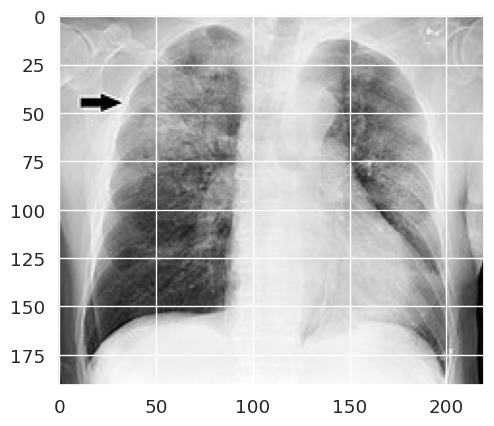

In [ ]:
plt.imshow(test_image)

In [ ]:
test_image.shape

(191, 220, 3)

In [ ]:
#resize this image
test_image=cv2.resize(test_image, (256,256))

In [ ]:
#reshape
test_input=test_image.reshape(1,256,256,3)

In [ ]:
# Check the input shape required by the first layer
print(model.layers[0].input.shape)

# Flatten the image after it has been converted to grayscale
test_input = test_image.reshape(1, 256*256)



(None, 196, 196, 1)


ValueError: cannot reshape array of size 196608 into shape (1,65536)